# VAE for MNIST Dataset

In [1]:
import math
import torch
import random
import platform
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn, optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
if platform.system() == "Darwin" and platform.machine().startswith("arm"):
    DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
else:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(DEVICE)

mps


In [3]:
def display_image_grid(images, labels=None, class_names=None, num_cols=4, figsize=(10, 20)):
    """
    Display a grid of images with optional labels using Matplotlib.

    Args:
        images: List or tensor of images to display (e.g., shape [N, H, W] or [N, C, H, W]).
        labels: List or tensor of numerical labels (optional).
        class_names: List of class names corresponding to numerical labels (optional).
        num_cols: Number of columns in the grid.
        figsize: Tuple specifying the figure size (width, height).
    """
    num_images = len(images)
    num_rows = math.ceil(num_images / num_cols)
    
    # Create the plot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration
    
    for i in range(num_cols * num_rows):
        ax = axes[i]
        
        if i < num_images:
            # Convert tensors to numpy arrays if necessary
            image = images[i]
            if isinstance(image, torch.Tensor):
                image = image.numpy().transpose(1, 2, 0) if image.ndim == 3 else image.numpy()
            
            # Display the image
            ax.imshow(image.squeeze(), cmap='gray' if image.ndim == 2 else None, aspect='auto')
            
            # Add labels if provided
            if labels is not None:
                label = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
                if class_names:
                    label = class_names[label]
                ax.set_title(label, fontsize=8, pad=2)  # Smaller title and closer to the image
        else:
            ax.axis('off')  # Turn off axes for empty grid cells
        
        ax.axis('off')  # Remove axis ticks and labels
    
    # Adjust layout to minimize gaps
    fig.subplots_adjust(wspace=0.2, hspace=0.5, left=0, right=1, top=0.95, bottom=0.05)
    # fig.subplots_adjust(wspace=0.01, hspace=0.01, left=0, right=1, top=1, bottom=0)
    plt.show()

In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim = 200, z_dim = 20):
        super().__init__()
        self.img2hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden2mu = nn.Linear(hidden_dim, z_dim)
        self.hidden2sigma = nn.Linear(hidden_dim, z_dim)

        self.z2hidden = nn.Linear(z_dim, hidden_dim)
        self.hidden2img = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h = F.relu(self.img2hidden(x))
        mu, sigma = self.hidden2mu(h), self.hidden2sigma(h)

        return mu, sigma
    
    def decode(self, z):
        h = F.relu(self.z2hidden(z))
        return F.sigmoid(self.hidden2img(h))
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        eps = torch.randn_like(sigma)
        z = mu + sigma*eps
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, sigma

In [5]:
INPUT_DIM = 784
H_DIM = 200
Z_DIM = 20
EPOCHS = 50
BATCH_SIZE = 32
LR_RATE = 1e-4 

In [6]:
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
model = VAE(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")

In [7]:
def train():
    model.train()
    for epoch in tqdm(range(EPOCHS)):
        for x,_ in train_loader:
            x = x.to(DEVICE).view(x.shape[0], -1)
            reconstructed_x, mu, sigma = model.forward(x)
            reconstruction_loss = loss_fn(reconstructed_x, x)
            kl_div = -1 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
            loss = reconstruction_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [8]:
train()

100%|██████████| 10/10 [01:10<00:00,  7.03s/it]


In [12]:
def generate(no_examples=10):
    z = torch.rand(no_examples,Z_DIM).to(DEVICE)
    with torch.no_grad():
        output = model.decode(z).view(-1, 1, 28, 28)
    return output

The problem with a standard Variational Autoencoder (VAE) is that we have no control over which type of image is generated when sampling random noise from the latent space. The generated images are determined solely by the learned distribution, without any way to specify desired characteristics or categories.

To address this, we can use a Conditional Variational Autoencoder (CVAE). In a CVAE, we include the class label or ID as an additional condition during training. This allows us to control the type of image generated during inference by specifying the desired class label. 

For now, since we are using a VAE, we can only sample from the latent space distribution learned during training. If specific types of images are required, a workaround is to sample latent vectors corresponding to those types from the source dataset and initialize the distribution accordingly.

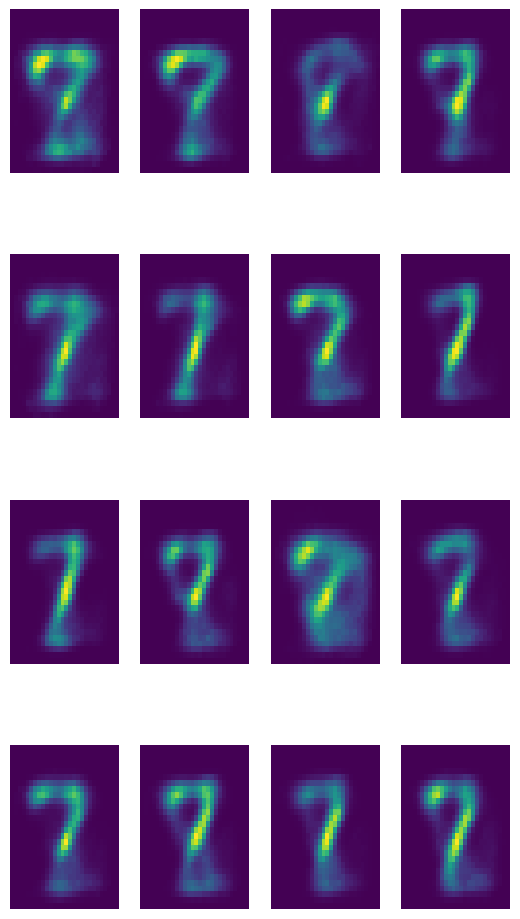

In [15]:
imgs = generate(no_examples=16).to('cpu')
display_image_grid(imgs, figsize=(5,10))

### Workaround: Sampling from the Source Dataset

In the absence of a Conditional Variational Autoencoder (CVAE), we cannot directly control the type of image generated by the model. However, a practical workaround is to sample latent vectors that correspond to specific types of images from the source dataset. This involves the following steps:

1. **Encoding Specific Data Points:**
   - Select images of a particular category or type from the source dataset.
   - Pass these images through the encoder to obtain their corresponding latent representations.

2. **Latent Space Initialization:**
   - Use the sampled latent vectors as initial points for generating new images.
   - These vectors represent specific regions of the latent space associated with the desired type of image.

3. **Image Generation:**
   - Pass the sampled latent vectors through the decoder to reconstruct or generate new images similar to the selected category.

While this method does not provide full control over the generation process, it allows for targeted sampling based on the source dataset. It is a useful strategy when using a standard VAE but falls short compared to the precision and flexibility of a CVAE.

torch.Size([16, 784])


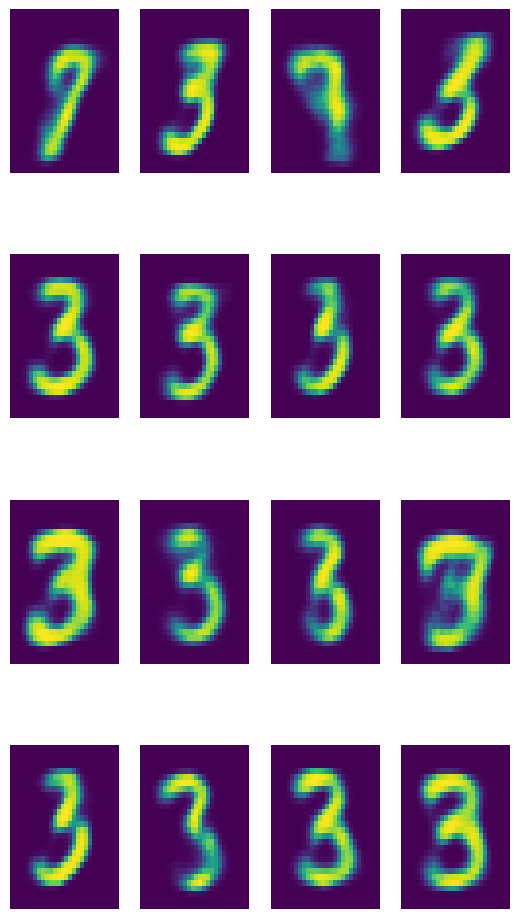

In [54]:
def generate_with_digit_workaround(digit, no_examples=10):
    # Encode images of the specified digit from the source dataset
    # Assuming `source_dataset` contains images and labels
    source_images = []
    while len(source_images) < no_examples:
            imgs, labels = next(iter(train_loader))  # Get a single batch
            source_images = source_images + [img for img, label in zip(imgs, labels) if label.item() == digit]
    
    source_images = torch.stack(source_images[:no_examples]).to(DEVICE)
    source_images = source_images.view(source_images.shape[0], -1)
    print(source_images.shape)
    # Obtain latent representations from the encoder
    with torch.no_grad():
        mu, sigma = model.encode(source_images)

    # Decode the latent representations to generate new images
    with torch.no_grad():
        output = model.decode(mu+ sigma ).view(-1, 1, 28, 28)

    return output

# Example usage
imgs = generate_with_digit_workaround(3, no_examples=16).to('cpu')
display_image_grid(imgs, figsize=(5, 10), num_cols=4)